# 导入

## 导入包
这些是机器学习最常用的包, 值得系统学习:
* numpy
* pandas
* matplotlib
* seaborn
* scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("Set2")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

## 定义绘图函数
* 为了方便对所有特征进行比较, 建议对连续型特征进行离散化后, 也用这个绘图函数.

In [2]:
def plot_category(feature, group=None):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    sns.countplot(x=feature, hue=group, data=df, ax=ax0)
    sns.barplot(x=feature, y="Survived", hue=group, data=df, ax=ax1)
    ax1.hlines(
        Survived_avg,
        -0.5,
        df[feature].nunique() - 0.5,
        colors="red",
        linestyles="dashed",
    )
    if not group:
        plt.suptitle(feature)
    else:
        plt.suptitle(feature + " | " + group)


## 导入数据

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df = pd.concat([df_train, df_test]).reset_index().drop(["index"], axis=1)
n_train = df_train.shape[0]
n_all = df.shape[0]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 关于字段
* PassengerId: 整数编号, 对于没有什么用, 仍然保留它, 如果以后样本打乱顺序, 可以通过它来快速定位.
* Survived: 因变量, 训练集里面都是0或者1, 表示是否生存, 测试集里面都是NaN

##### 特征:
* Pclass: 表示阶层, 越小表示阶层越高, 从生存率高低或者Fare的平均值高低可以看出这一点.
* Sex: 性别, "女士孩子优先"原则让性别对生存率影响较大.
* Age: 年龄, "女士孩子优先"原则应该会让未成年人的生存率提高, 其他各个年龄段的生存率是否不同呢?
* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* Embarked: 上船地点.

##### 粗粗看起来没有什么用处, 但是, 如果考虑与其他乘客之间的关系的话, 对预测生死有可能有帮助的特征:
* Name: , 姓名好像无法决定生死, .
* Ticket: 船票号码, 粗粗看起来没有什么用处, 如果考虑与其他乘客之间的关系的话, 对预测生死有很大的帮助.
* Cabin: 船舱号码, 粗粗看起来没有什么用处, 如果考虑与其他乘客之间的关系的话, 对预测生死有很大的帮助.
* SibSp: 兄弟姐妹或者配偶的个数
* Parch: 父母或者孩子的个数

## 关于因变量

In [4]:
Survived_avg = np.around(df.Survived.mean(), decimals=2)
print("全局生存率: ", Survived_avg)

全局生存率:  0.38


发现生或死比例并不是太悬殊, 否则的话, 要重点考虑类别平衡的问题了.

## 观察缺失值

In [5]:
df.isna().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

* Survived缺失的都是测试集的部分
* Cabin, Age缺失比较严重, 如果一定要使用它们, 需要比较谨慎
* Embarked, Fare缺失较少

# 特征工程

## 新特征: Title

* "女士和孩子优先"原则下, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可
* "女士和孩子优先"原则下, 男孩有必要从男性中分离出来, 男孩称为"boy", 成年男性称为"man"
* 为了和原先的特征"Sex"作区分, 称为"Title", 这两个特征的信息量是有比较大的重叠的, 可以考虑保留其中一个.

In [6]:
df["Title"] = "man"
df.loc[df.Sex == "female", "Title"] = "woman"
df.loc[df["Name"].str.contains("Master"), "Title"] = "boy"
df.Title.value_counts(normalize=True)

man      0.597403
woman    0.355997
boy      0.046600
Name: Title, dtype: float64

* man占了59.7%左右, woman占了35.6%左右, 男孩占了4.7%左右.
* 后面会发现这个占比很重要, man的占比很大, 但难以预测出幸存者, 这就是为什么最高分(83%左右)难以超出基准分(性别模型, 76.6%)太多的主要原因.

### 可视化

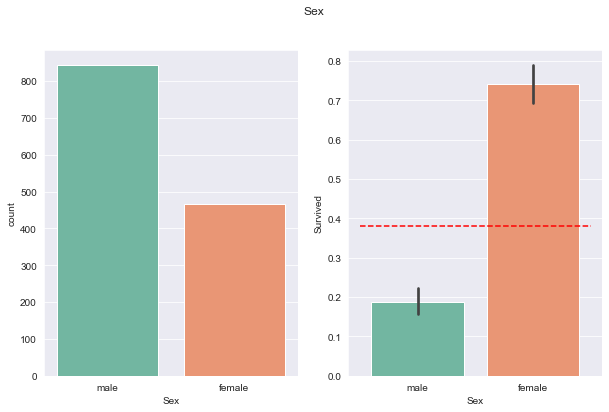

In [7]:
plot_category("Sex")

* 发现male生存率远远低于平均值, female生存率远远高于平均值, 这就是为什么简单的"gender model", 正确率就高达76.6%的原因.

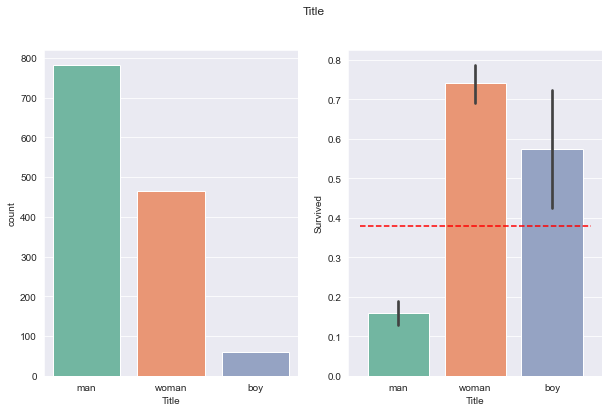

In [8]:
plot_category("Title")

* 发现boy虽然也是男性, 但是生存率与man截然不同, man生存率不到20%, 而boy生存率接近60%
* 说明对男性分成细分成两类, 是有价值的
* 有遗憾的地方在于: boy的占比太小了, 对整体成绩的提升非常有限(理论上, 准确率最多提高4.7%左右)

## 新特征: Pfare

* Fare: 船票的总价(一张船票有可能让好几个乘客上船)
* 因此, Fare是一个交叉性特征, 同时考虑了平均价格和一张票的乘客数量
* 对Fare这个特征进行"提纯", 求平均价格(Pfare), 平均价格更能体现出乘客的地位, 从而反映在生存率上.

In [9]:
df.Fare.replace(0, np.NaN, inplace=True)
df["Pfare"] = df["Fare"] / df.groupby("Ticket")["Ticket"].transform("count")

### 可视化

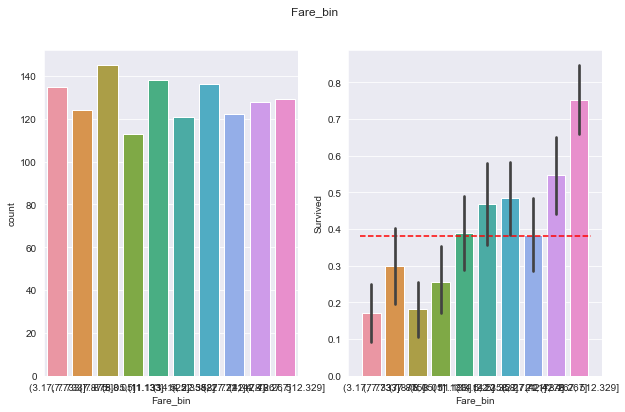

In [10]:
df["Fare_bin"] = pd.qcut(df["Fare"], 10)
plot_category("Fare_bin")

* 倒数第3个, 破坏了单调性, 估计是票中的乘客数造成了干扰.

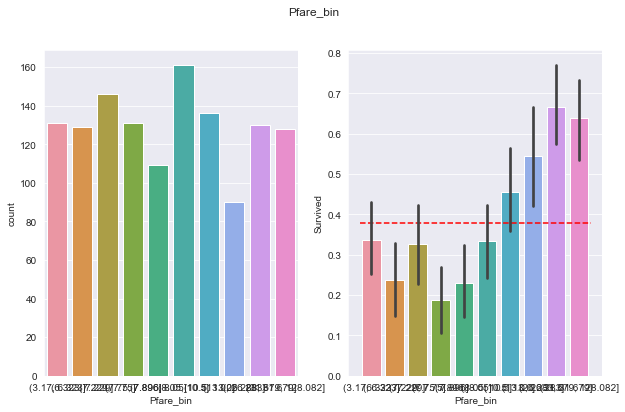

In [11]:
df["Pfare_bin"] = pd.qcut(df["Pfare"], 10)
plot_category("Pfare_bin")

* 除了低价位的3个区间, 其他的7个区间都是Pfare越高生存率越高, 符合预期.
* 对比Fare与Pfare的图形, 发现Pfare的单调性更好.

## Pclass

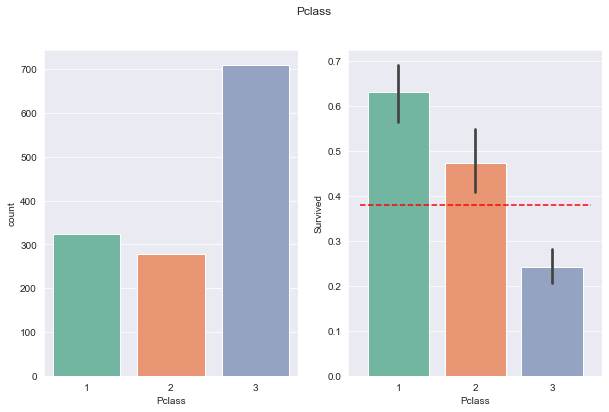

In [12]:
plot_category("Pclass")

* 发现等级越高, 生存率越高, 符合预期

## Age

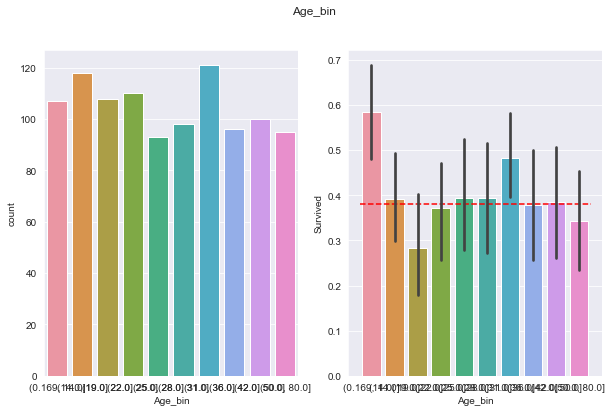

In [13]:
df["Age_bin"] = pd.qcut(df["Age"], 10)
plot_category("Age_bin")

* 除了第一个区间(低年龄段), 其他区间的生存率都在平均生存率附近
* 但是低年龄段已经通过Title体现过了
* 因此, Age很可能是信息量低的特征, 可以考虑舍掉.

## SibSp

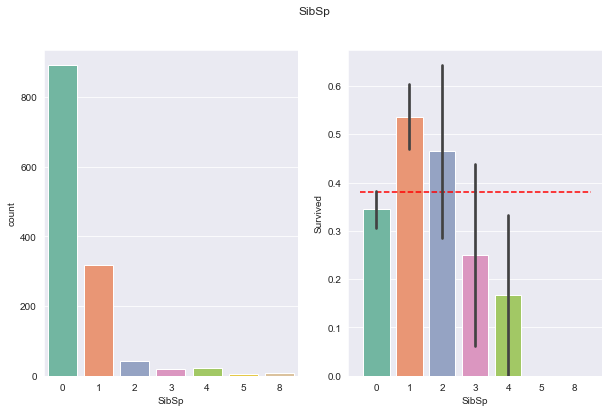

In [14]:
plot_category("SibSp")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 平均值附近
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Parch

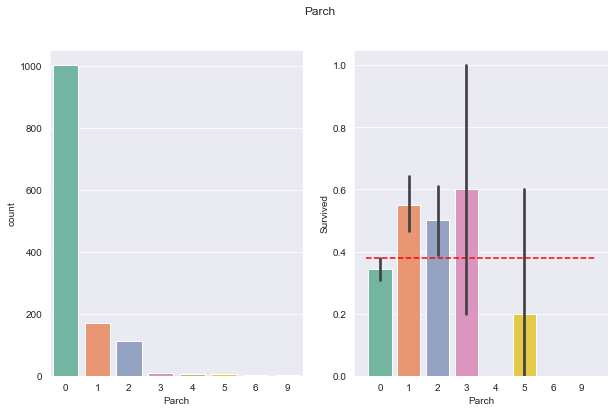

In [15]:
plot_category("Parch")

* 当为0时, 稍微低于平均值
* 当为1时, 稍微高于平均值
* 当为2时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性.

## Family

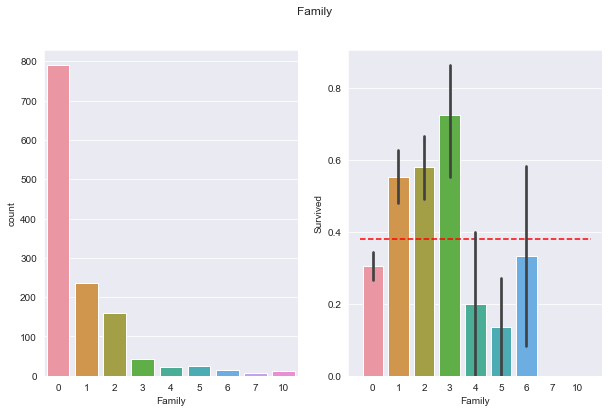

In [16]:
df["Family"] = df.SibSp + df.Parch
plot_category("Family")

* 当为0时, 稍微低于平均值
* 当为1或2或3时, 稍微高于平均值
* 其他的取值因为样本少, 不做评价.
* 总体来看, 有弱预测性, 但是比SibSp, Parch都要强.

## Embarked

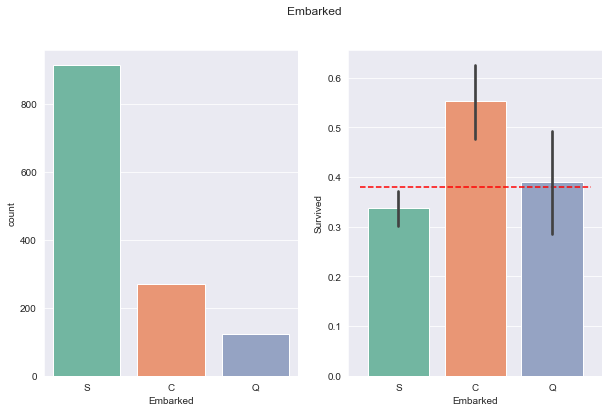

In [17]:
plot_category("Embarked")

* 取值为C时, 高于平均值
* 取值为S时, 低于平均值
* 取值为Q时, 在平均值附近
* 总体来看, 是中等预测能力的特征.

## 单个特征的预测能力排名(基于图形主观判断):
#### 强预测能力特征:
* Title, Sex
* Pclass
* Pfare

#### 中预测能力特征:
* Embarked

#### 弱预测能力特征:
* Family, Parch, SibSp

#### 无预测能力特征:
* Age

## Title与Pclass交叉

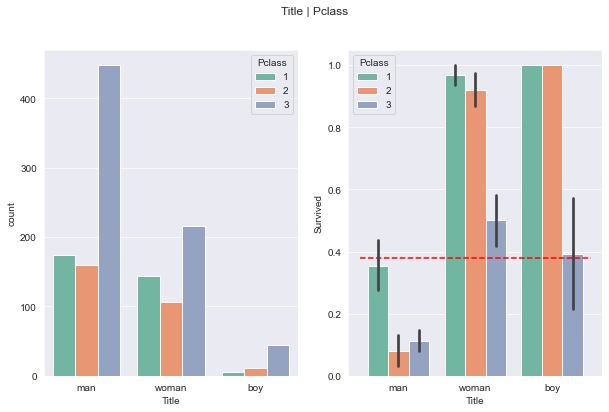

In [18]:
plot_category("Title", group="Pclass")

* man不管是什么Pclass, 都无法达到平均生存率
* Pclass == 1 的man稍低于平均生存率, 如果将来要寻找man幸存者, 这个群体中有可能会找到.
* woman不管是什么Pclass, 都超过了平均生存率
* Pclass == 3 的woman稍高于平均生存率, 如果将来要寻找woman遇难者, 这个群体中有可能会找到.
* Pclass == 3 的boy, 接近于平均生存率, 这个是比较让我吃惊的地方, 这个群体优势(年龄)与劣势(性别)正好抵消了.
* 其他阶层的boy, 生存率高达100%!, 但是要当心, 因为样本个数较少.

## Title与Pfare交叉

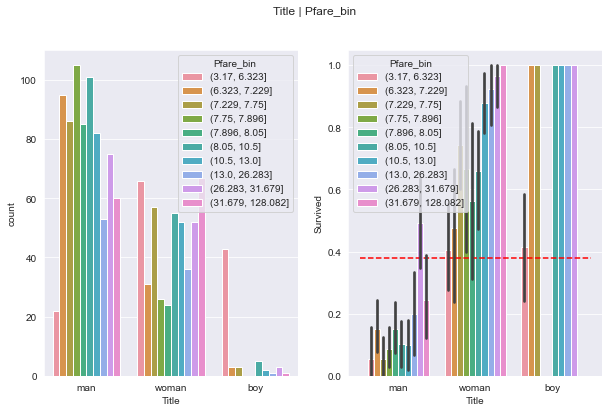

In [19]:
plot_category("Title", group="Pfare_bin")

* 幸运的是, 结合Pfare, 发现了一小部分man的生存率高于平均值.
* 最低档Pfare的woman或boy, 生存率在平均值附近.

## Pclass与Pfare交叉

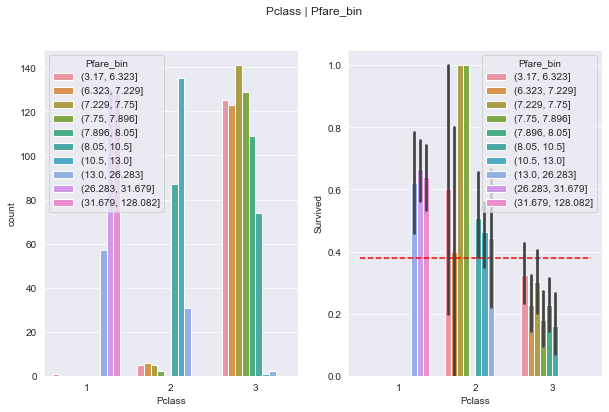

In [20]:
plot_category("Pclass", group="Pfare_bin")

* Pclass == 1的生存率都高于平均值
* 低价区的Pclass == 2的生存率在平均值附近
* Pclass == 3的生存率都低于平均值

## Title与Embarked交叉

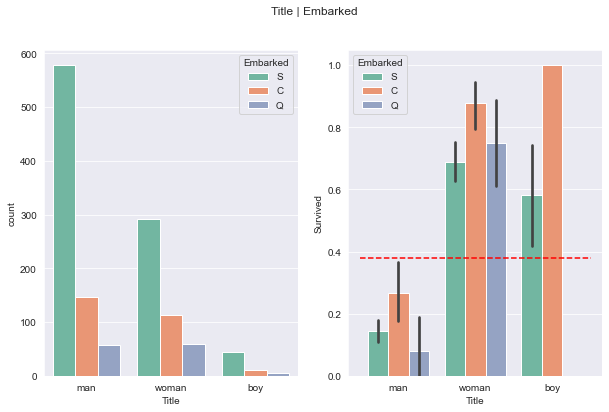

In [21]:
plot_category("Title", group="Embarked")

* Embarked == Q的boy, 生存率为0%, 可能是有偶然性的, 因为这样的样本太少.
* 其他的group形状符合预期.

In [22]:
df.loc[(df.Title == "boy") & (df.Embarked == "Q")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family
16,17,0.0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
171,172,0.0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
278,279,0.0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
787,788,0.0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5
946,947,NaN,3,"Rice, Master. Albert",male,10.0,4,1,382652,29.125,NaN,Q,boy,4.854167,"(27.721, 42.4]","(3.17, 6.323]","(0.169, 14.0]",5


* 发现Embarked == Q的boy应该是在自于同一个家庭(成为"Rice"家庭), 同一个家庭出现同生同死的概率相当大(下文中会验证这一点), 不巧的是, 这个家庭正好落在了"同死"这个状态.

## Pclass与Embarked交叉

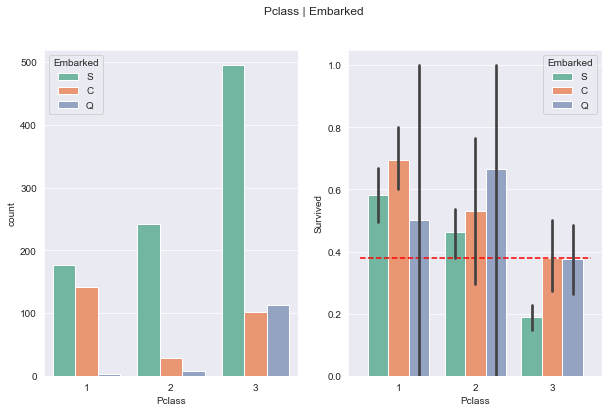

In [23]:
plot_category("Pclass", group="Embarked")

* 图形形状基本上是符合预期的.
* "Pclass == 2, Embarked == Q"的生存率高于我的预期了, 看看具体的数据:

In [24]:
df.loc[(df.Pclass == 2) & (df.Embarked == "Q")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Pfare,Fare_bin,Pfare_bin,Age_bin,Family
303,304,1.0,2,"Keane, Miss. Nora A",female,NaN,0,0,226593,12.3500,E101,Q,woman,12.3500,"(11.133, 14.5]","(10.5, 13.0]",NaN,0
322,323,1.0,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,NaN,Q,woman,12.3500,"(11.133, 14.5]","(10.5, 13.0]","(28.0, 31.0]",0
626,627,0.0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.3500,NaN,Q,man,12.3500,"(11.133, 14.5]","(10.5, 13.0]","(50.0, 80.0]",0
893,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,man,9.6875,"(8.05, 11.133]","(8.05, 10.5]","(50.0, 80.0]",0
907,908,NaN,2,"Keane, Mr. Daniel",male,35.0,0,0,233734,12.3500,NaN,Q,man,12.3500,"(11.133, 14.5]","(10.5, 13.0]","(31.0, 36.0]",0
975,976,NaN,2,"Lamb, Mr. John Joseph",male,NaN,0,0,240261,10.7083,NaN,Q,man,10.7083,"(8.05, 11.133]","(10.5, 13.0]",NaN,0
1084,1085,NaN,2,"Lingane, Mr. John",male,61.0,0,0,235509,12.3500,NaN,Q,man,12.3500,"(11.133, 14.5]","(10.5, 13.0]","(50.0, 80.0]",0


* "Pclass == 2, Embarked == Q"的生存率高于我的预期, 主要原因这个group的训练集样本只有3个, 偶然性太大, 没有什么参考性.

## Pfare与Embarked交叉

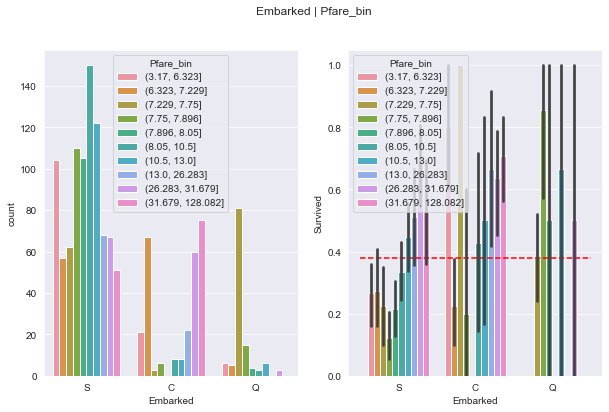

In [25]:
plot_category("Embarked", group="Pfare_bin")

* 基本上符合预期

## 二重交叉特征预测能力排名(基于图形, 主观判断)
#### 强预测能力:
* Title与Pclass交叉
* Title与Pfare交叉
* Pclass与Pfare交叉
* Title与Embarked交叉

#### 中预测能力:
* Pclass与Embarked
* Pfare与Embarked

## Title, Pclass, Pfare交叉

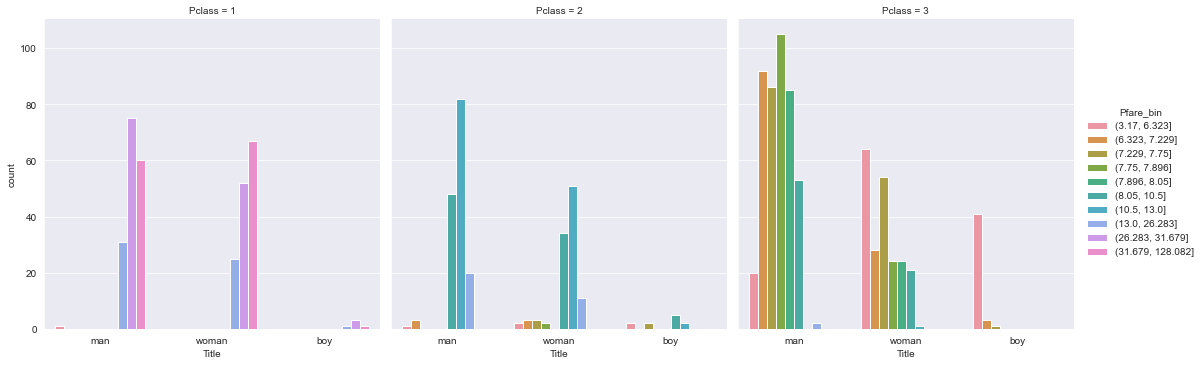

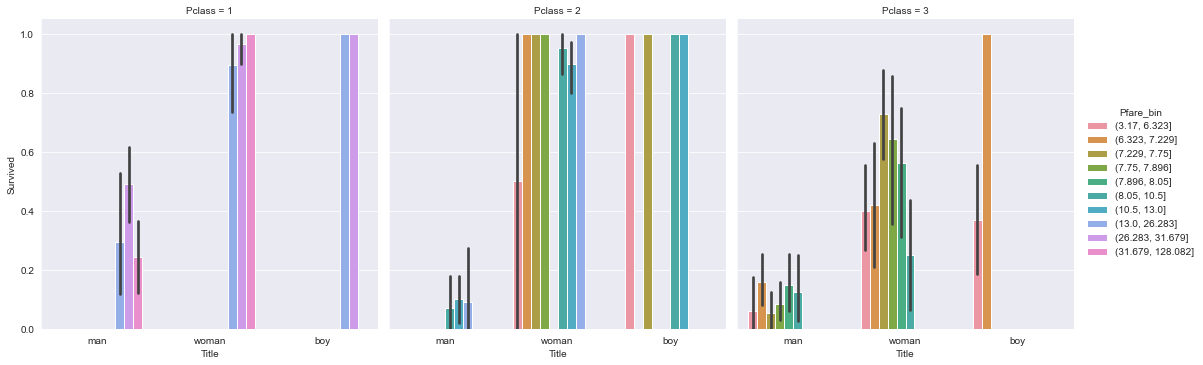

In [26]:
sns.catplot(x="Title", y=None, hue="Pfare_bin", col="Pclass", data=df, kind="count")
sns.catplot(x="Title", y="Survived", hue="Pfare_bin", col="Pclass", data=df, kind="bar")

* Pclass == 1, 倒数第2档的man, 生存率高于平均值
* Pclass == 3, Pfare在低档位的woman或者boy, 生存率在平均值附近

## Title, Pclass, Embarked交叉

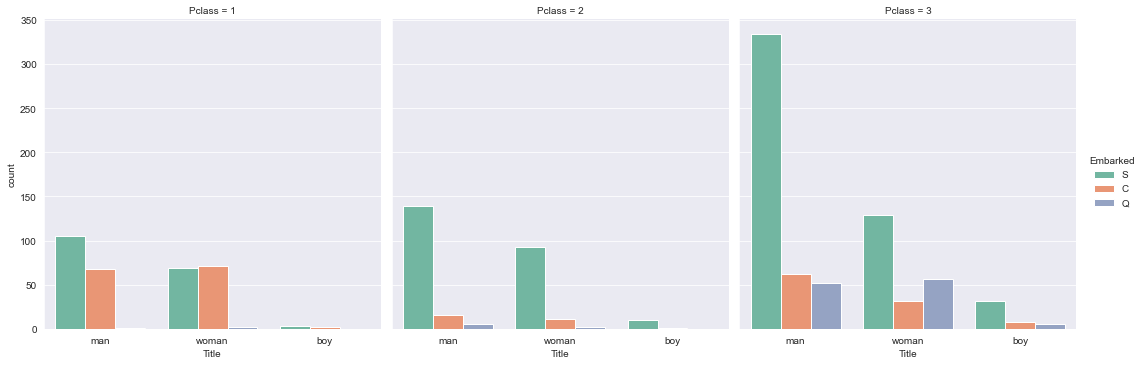

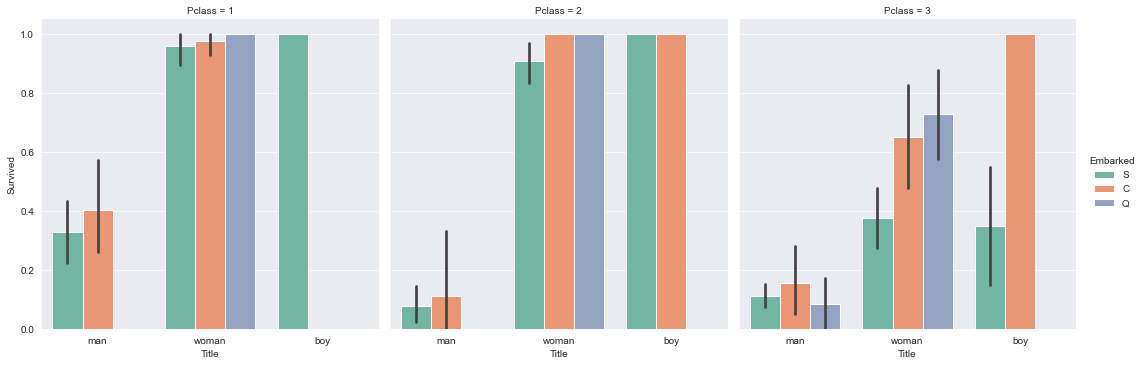

In [27]:
sns.catplot(x="Title", y=None, hue="Embarked", col="Pclass", data=df, kind="count")
sns.catplot(x="Title", y="Survived", hue="Embarked", col="Pclass", data=df, kind="bar")

* Pclass == 1的man生存率接近平均值
* Pclass == 3, Embarked == S的woman或者boy, 生存率接近平均值

## Title, Pfare, Embarked交叉

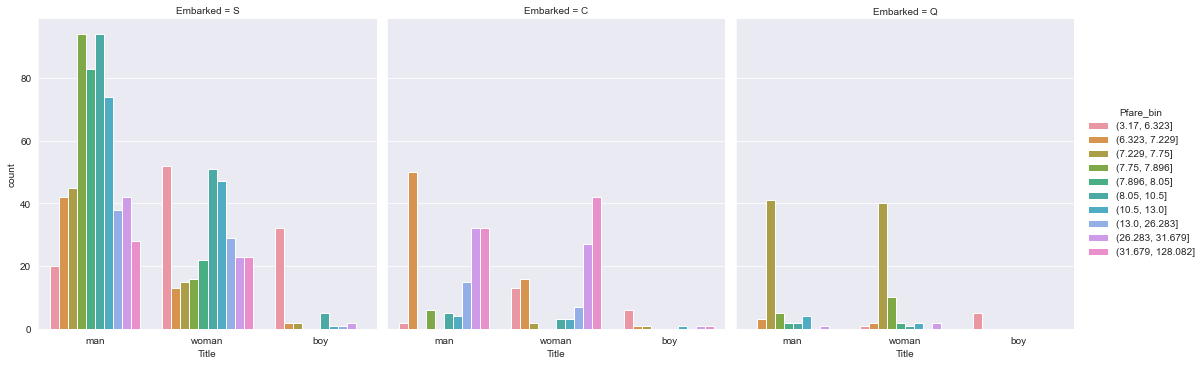

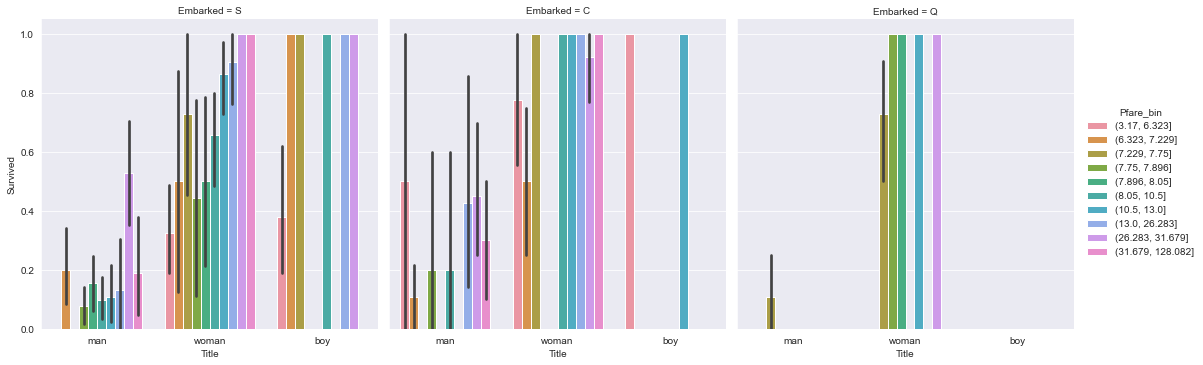

In [28]:
sns.catplot(x="Title", y=None, hue="Pfare_bin", col="Embarked", data=df, kind="count")
sns.catplot(x="Title", y="Survived", hue="Pfare_bin", col="Embarked", data=df, kind="bar")

* 对于man, 在高Pfare档位, 生存率接近于平均值
* 对于woman, 在Embarked == S, 低Pfare档位, 生存率接近于平均值
* 对于boy, 在Embarked == S, 低Pfare档位, 生存率接近于平均值
* 其他的基本上符合预期, 不符合预期的部分是因为小样本造成的.

## Pclass, Pfare, Embarked交叉

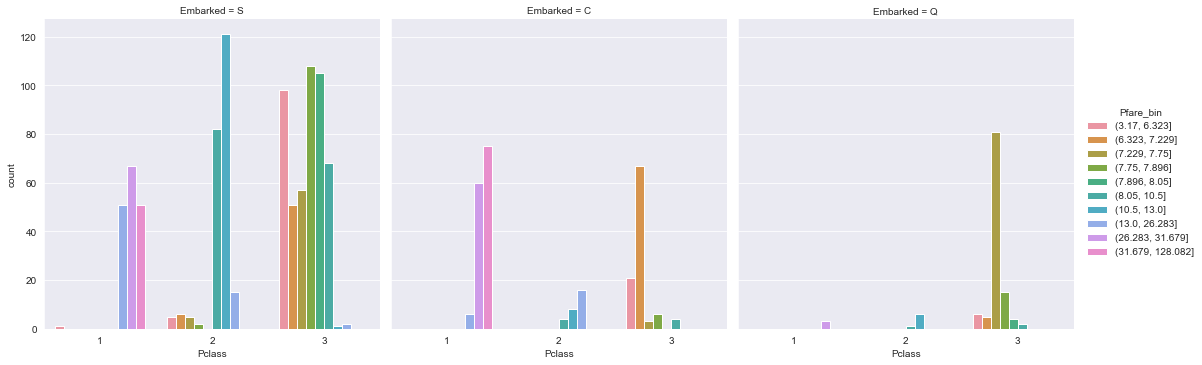

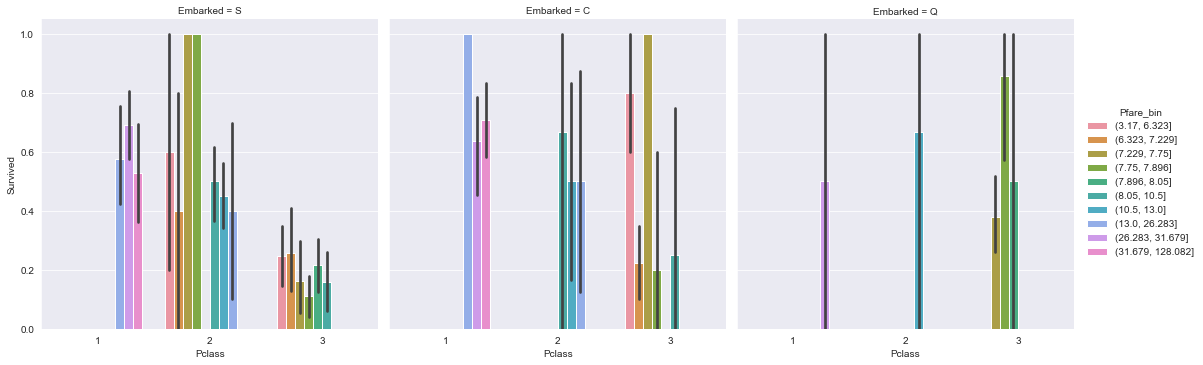

In [29]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", col="Embarked", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", col="Embarked", data=df, kind="bar")

* Pclass == 3的时候, 现象非常奇特, 当Embarked == S时, 普遍低于平均值, 当Embarked == "C"或者"Q"时, 经常出现高于平均值的情况.

## Title, Pclass, Pfare, Embarked交叉

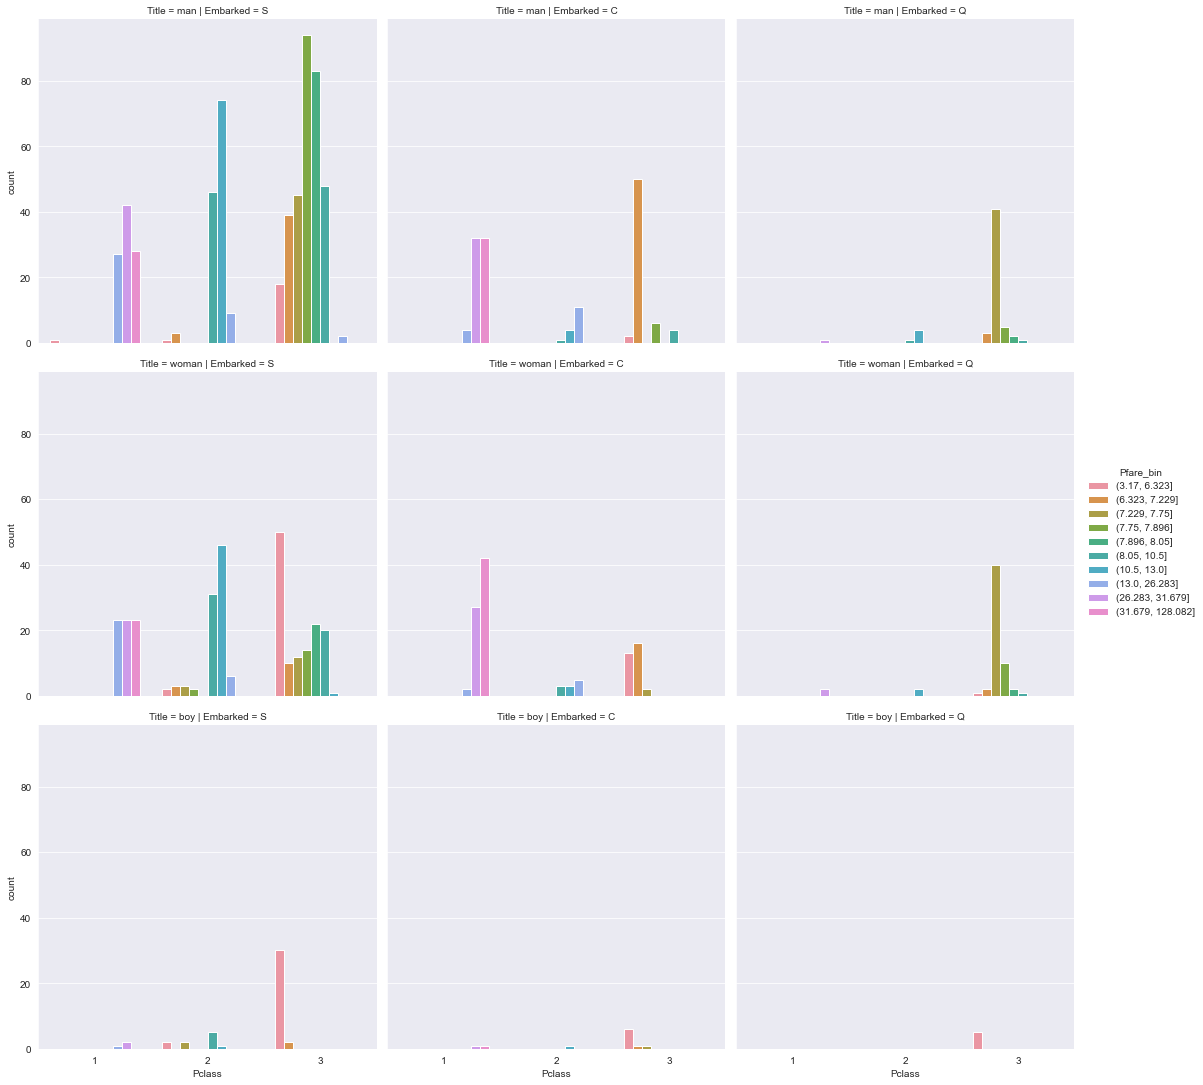

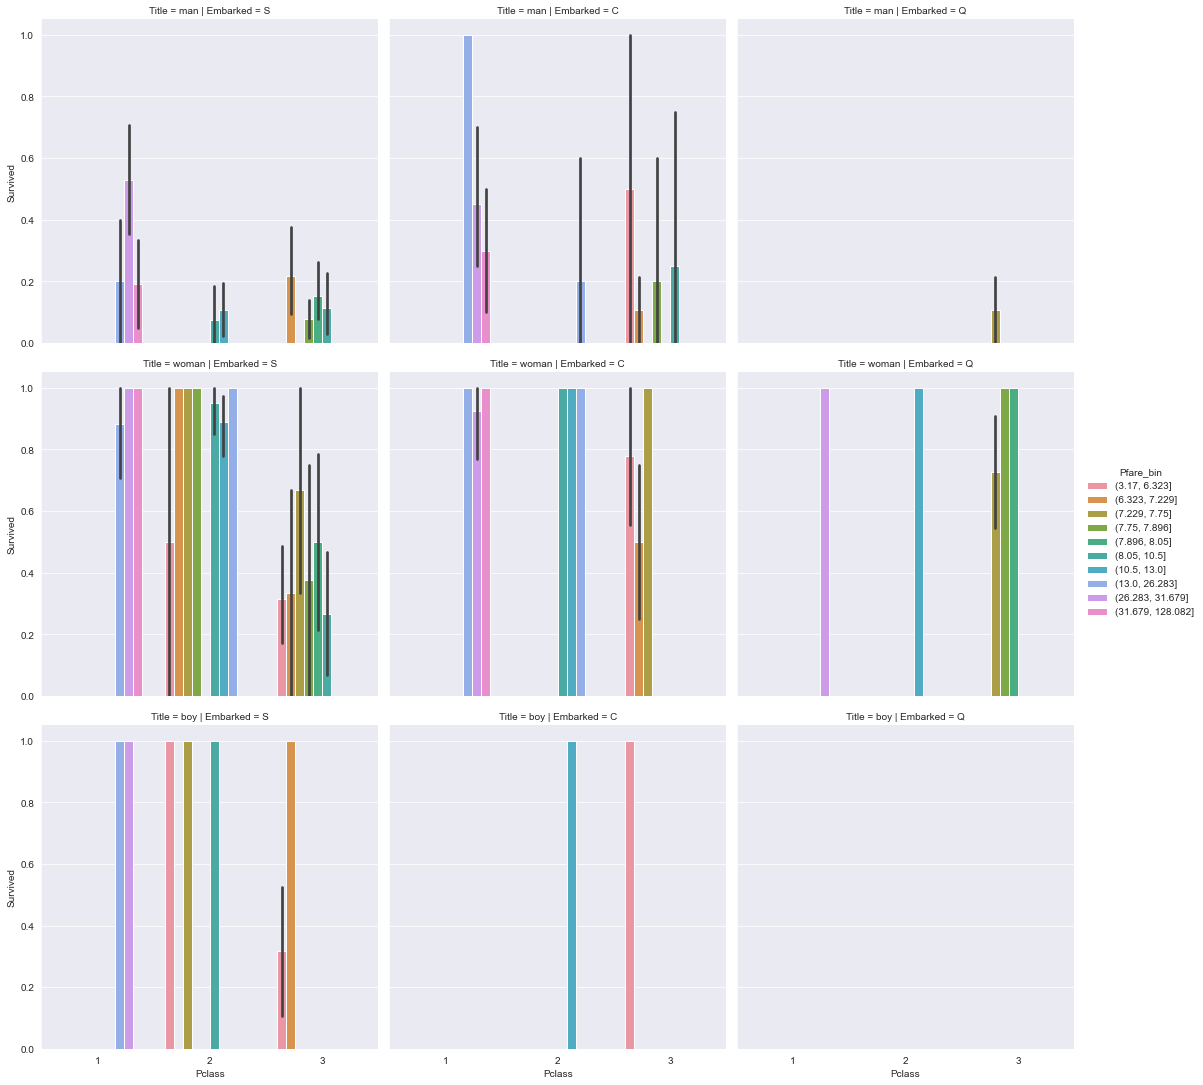

In [30]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Title", col="Embarked", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Title", col="Embarked", data=df, kind="bar")

* 对于man, Pclass == 1, Embarked == "S"或者"C"的某些Pfare档位上, 生存率高于平均值
* 对于woman, Pclass == 3, Embarked == "S", 大部分Pfare档位上, 生存率接近于平均值
* 对于boy, Pclass == 3, Embarked == "S", 低Pfare档位上, 生存率接近于平均值, 还有一些是小样本情况.

## 小结
* 对于单个特征进行了排名, 对特征的预测能力有个总体的判断
* 使用二重交叉特征, 三重交叉特征, 四重交叉特征, 对于发现那些异常情况非常有帮助.
* 发现二重交叉特征, 三重交叉特征的异常情况是和四重交叉特征的异常情况不矛盾的, 是一致的.
* 因此, 只保留下四重交叉特征的异常情况:
* 对于man, Pclass == 1, Embarked == "S", Pfare倒数第2档位上, 生存率 > 50%
* 对于woman, Pclass == 3, Embarked == "S", 大部分Pfare档位上, 生存率 < 50%
* 对于boy, Pclass == 3, Embarked == "S", 低Pfare档位上, 生存率 < 50%

In [31]:
df.loc[(df.Title == "man") 
       & (df.Pclass == 1)
       & (df.Embarked.isin(["S"])) 
       & (26.832 < df.Pfare) 
       & (df.Pfare <= 31.679),
       "Survived"].mean()

0.5833333333333334

In [32]:
df.loc[(df.Title == "woman") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"])),
       "Survived"].mean()

0.375

In [39]:
df.loc[(df.Title == "boy") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"])) 
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3157894736842105

* 验证了上面说的三种异常情况.
* 对于man的异常情况, 生存率是58%, 虽然高于平均生存率(38%), 但是只比50%高一点点, 考虑到有可能过拟, 这个生存率还是无法做出预测.
* 对于woman或者boy的异常情况, 生存率分为了37.5%, 31.6%, 看起来还可以, 但是考虑有可能过拟, 做预测的准确率还是不能太乐观.
* 后面会发现更强的特征, 因此, 这些交叉特征先保留, 先不做预测, 等生成了更强的特征, 再考虑结合那些交叉特征.

# WCG模型

但是别忘了, 之前的特征分析里面, 暂时忽略分析了Name, Ticket, Cabin这三个特征

这三个特征看似没用, 因为属于level很大的类别型, 但是WCG模型厉害就厉害在这点, 化腐朽为神奇.


## 关于Woman-Child-Groups (WCG)
#### 注意, WCG不同于WCG模型. 
#### WCG是一种分组方法.
#### WCG模型是基于WCG的预测模型.
### WCG用一句话来概括, 就是: 将一个家庭内的所有女性(包括女保姆)或孩子认定为一组.
#### 需要特别留意的是: 一个家庭内的成年男性并没有分到组里面.
#### 这背后的逻辑是: 
1. 发现一个家庭内的成员同生或同死的概率极大.
2. 男人因为"女士和孩子优先"这条规则, 并不遵循第1条逻辑.
3. 虽然传统意义上, 女保姆不算是家庭成员, 但是女保姆也是符合"女士和孩子优先"这条规则的, 因此, 也会和东家一起上救生船或者一起葬身大海.

### 总结出GroupId(用来认定是否是传统意义上的一家人): 
### **GroupId = Surname + Pclass + Ticket + Fare + Embarked**
这个公式里面, 没用Cabin, 有两个理由:
1. Cabin与Ticket信息是有冗余的.
2. Cabin的缺失率太高了.

其中Ticket舍掉最后一位, 因为发现有些实际上是一家人, 但是Ticket最后一位不同(这种情况并不多见, 发现这种现象的人观察力惊人!)

#### 比如这两个乘客, Surname, Pclass, Fare, Embarked都是一样的, 只有Ticket最后一位不同, 可以推测这两个大概率上是一家人:

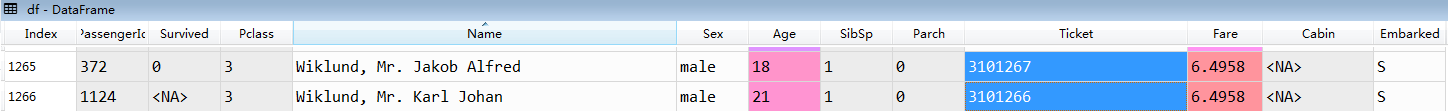

#### 后续处理:
1. 将所有的man的GroupId赋值为"noGroup", 因为前面提到了, man并不属于任何WCG.
2. 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup", 逻辑很简单, 单独一个人, 不能算是一个"Group", 
   另外, 对于预测毫无用处, 单独一个人无法用来预测其他乘客的生死, 因为没有其他同组成员了.

In [23]:
df["Surname"] = df["Name"].str.split(",").str[0]

df["Ticket_id"] = (
    df.Pclass.astype(str)
    + "-"
    + df.Ticket.str[:-1].astype(str)
    + "-"
    + df.Fare.astype(str)
    + "-"
    + df.Embarked.astype(str)
)

df["Group_id"] = df.Surname + "-" + df["Ticket_id"]

# 后续处理
df.loc[df.Title == "man", "Group_id"] = "noGroup"
df["WC_count"] = (
    df.loc[df.Title != "man"]
    .groupby("Group_id")["Group_id"]
    .transform("count")
)
df.loc[df.WC_count <= 1, "Group_id"] = "noGroup"

### 女保姆的认定

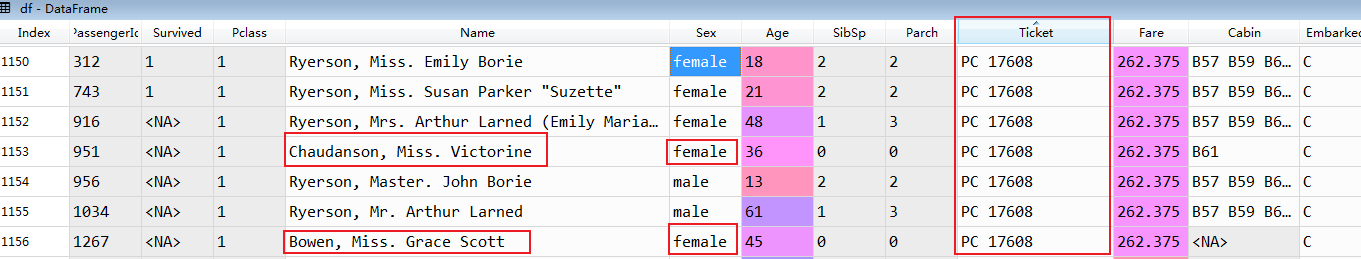

#### 红框圈出来的两个人, 发现除了Surname不符合GroupId的标准, 其他都符合, 即与其他5个, 有相同的Pclass, Ticket, Fare, Embarked, 但是Surname不同.

#### 定义: **TicketId = Pclass + Ticket + Fare + Embarked**

#### 女保姆的认定标准:
1. 不能是man, 因为WCG以及排除掉man了, 理论上有可能是boy, 实际发行找出来的都是woman, 这是将这类人命名为"女保姆"的原因.
2. GroupId为"noGroup", 这个很好理解, 如果这位乘客已经是某个Group里面的成员了, 不需要再加入到其他Group里面去了.
3. 存在与该样本TicketId相同的WCG(GroupId不能为"noGroup")

#### 认定为女保姆以后, 将该样本的GroupId修正为该WCG的GroupId, 即女保姆算是WCG成员.


#### **思考**: 前面对GroupId的后续处理中, 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup"(下文中简称为"规则2"), 
#### 基于女保姆的认定标准3, 意味着东家是一个人的话, 女保姆不会被认定为女保姆.
#### 那么, 规则2是不是有合理性呢?
#### 答案是有合理性, 因为规则2虽然会造成"东家是一个人的话, 女保姆不会被认定为女保姆", 
#### 但是更多的避免了"两个乘客恰好只是同票, 实际上没有任何关系, 既不是同一个家庭, 也不是东家与女保姆的关系".
#### 规则2要求家庭成员至少是2个, 那么那个"异姓"的, 是女保姆的概率就非常大了, 如果家庭成员只有1个, 那个"异姓"的, 是女保姆的概率比较小.

In [24]:
indices = []
count = 0
for i in range(n_all):
    if df.loc[i, "Title"] != "man" and df.loc[i, "Group_id"] == "noGroup":
        idx = np.flatnonzero(
            (df["Ticket_id"] == df.loc[i, "Ticket_id"])
            & (df["Group_id"] != "noGroup")
        )
        if len(idx):
            df.loc[i, "Group_id"] = df.loc[idx[0], "Group_id"]
            indices.append(i)
            count += 1
print("发现了{:d}个女保姆".format(count))

cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
df.loc[indices, cols]

发现了11个女保姆


,PassengerId,Survived,Name,Title,Group_id
337,338,1.0,"Burns, Miss. Elizabeth Margaret",woman,Spedden-1-1696-134.5-C
708,709,1.0,"Cleaver, Miss. Alice",woman,Allison-1-11378-151.55-S
950,951,NaN,"Chaudanson, Miss. Victorine",woman,Ryerson-1-PC 1760-262.375-C
1032,1033,NaN,"Daniels, Miss. Sarah",woman,Allison-1-11378-151.55-S
1067,1068,NaN,"Sincock, Miss. Maude",woman,Davies-2-C.A. 3311-36.75-S
1140,1141,NaN,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman,Zabour-3-266-14.4542-C
1171,1172,NaN,"Oreskovic, Miss. Jelka",woman,Cacic-3-31508-8.6625-S
1258,1259,NaN,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",woman,Panula-3-310129-39.6875-S
1262,1263,NaN,"Wilson, Miss. Helen Alice",woman,Spedden-1-1696-134.5-C
1266,1267,NaN,"Bowen, Miss. Grace Scott",woman,Ryerson-1-PC 1760-262.375-C


发现这11个女保姆里面, 有9个是测试集里面的, 最多可以提高成绩9/418=2.15%, 说明发现女保姆的努力是有价值的.

### WCG乘客的Title分布

In [25]:
number_of_groups = df.loc[df.Group_id != "noGroup", "Group_id"].nunique()
print("WCG的个数: {:d}".format(number_of_groups))
number_of_WCG_passengers = df.loc[
    df.Group_id != "noGroup", "Group_id"
].count()
print(
    "\nWCG乘客个数: {:d}".format(number_of_WCG_passengers)
)
composition = df.loc[df.Group_id != "noGroup", "Title"].value_counts()
print("\nWCG乘客的Title分布:")
print(composition.to_string())
print("\n全体乘客的Title分布:")
print(df.Title.value_counts().to_string())

print("\nWCG覆盖率:")
print((composition / df.Title.value_counts()).fillna(0.0))

WCG的个数: 80

WCG乘客个数: 230

WCG乘客的Title分布:
woman    171
boy       59

全体乘客的Title分布:
man      782
woman    466
boy       61

WCG覆盖率:
boy      0.967213
man      0.000000
woman    0.366953
Name: Title, dtype: float64


查看了WCG覆盖率, 应该能够瞬间明白为什么没有对boy再建模预测.

## 组内生存率

In [ ]:
df["WCSurvived"] = (
    df.loc[(df.Title != "man") & (df.Group_id != "noGroup")]
    .groupby("Group_id")
    .Survived.transform("mean")
)

In [ ]:
cols = ["PassengerId", "Survived", "WCSurvived", "Name", "Title", "Group_id"]
df.loc[df.Group_id == "Sage-3-CA. 234-69.55-S", cols]

### 组内生存率的分布

In [ ]:
print("WCSurvived all data values:")
print(df.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7, 5))
f = sns.countplot(y=df.WCSurvived)

发现组内生存率大部分是0.0或者1.0, 即同生同死的概率非常大, 这就是为什么组内生存率是一个非常强的特征的原因.

In [ ]:
df.loc[(df.WCSurvived == 0.75) | (df.WCSurvived == 0.5), cols].sort_values(by="Group_id")

有一些WCG, 全部成员都在测试集里面.

因此, 无法计算出组内生存率, 但是, 可以利用到"同生同死"这个性质.

In [ ]:
test_groups = set(df[n_train:].Group_id.unique()) - set(
    df[:n_train].Group_id.unique()
)
df.loc[df.Group_id.isin(test_groups), cols].sort_values(by="Group_id")

全部成员都在测试集里的家族有: Gibsons, Klasens, Peacocks, van Billiards.  

### 试图去寻找其他特征:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Woman-child-groups analysis", fontsize=14)
a = sns.barplot(
    x="Pclass", y="Survived", data=df[df.Group_id != "noGroup"], ax=ax[0]
).set_ylabel("Survival rate")
b = sns.barplot(
    x="Embarked", y="Survived", data=df[df.Group_id != "noGroup"], ax=ax[1]
).set_ylabel("Survival rate")

发现当Pclass == 3时, 大概率死亡, 当Pclass为其他的时候, 大概率是生存

其他特征没有Pclass那么强

### 通过Pclass对"全部成员都在测试集里的家族"的生存率进行赋值.

In [ ]:
df.loc[df.Group_id.isin(test_groups), "WCSurvived"] = 0
df.loc[
    (df.Group_id.isin(test_groups)) & (df.Pclass != 3), "WCSurvived"
] = 1

查看测试集的组内生存率分布

In [ ]:
print("WCSurvived test values:")
print(df[n_train:].WCSurvived.value_counts().to_string())

## 基于组内生存率, 进行预测
1. 如果boy的组内生存率是100%, 那么预测他生存, 否则, 预测他死亡.
2. 如果woman的组内生存率是0%, 那么预测她死亡, 否则, 预测她生存
3. 如果乘客是man, 一律预测他死亡.

### 背后的逻辑:
1. boy的死亡率整体上是比较高的, 所以默认预测为死亡, 预测他生存, 需要比较严苛的条件(组内生存率是100%)
2. woman的死亡率整体上是比较低的, 所以默认预测为生存, 预测她死亡, 需要比较严苛的条件(组内生存率是0%)
3. man的死亡率极高, 光凭组内生存率, 已经无法预测哪些是幸存者了, 所以, 一律预测为死亡.

In [ ]:
df.loc[n_train : n_all - 1, "Predict"] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Sex == "female")] = 1
df.loc[n_train : n_all - 1, "Predict"][
    (df.Sex == "female") & (df["WCSurvived"] == 0)
] = 0
df.loc[n_train : n_all - 1, "Predict"][
    (df.Title == "boy") & (df["WCSurvived"] == 1)
] = 1

测试集里面, 被预测为生存的boy:

In [ ]:
print("The following 8 males are predicted to live:")
cols = ["PassengerId", "Name", "Title", "Group_id"]
df[n_train:][cols].loc[(df.Title == "boy") & (df.Predict == 1)]

测试集里面, 被预测为死亡的woman:

In [ ]:
print("The following 15 females are predicted to die:")
df[n_train:][cols].loc[(df.Title == "woman") & (df.Predict == 0)]

## 提交WCG模型的预测结果

In [ ]:
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_gender.csv", index=False)
print("WCG_gender submission was successfully saved!")
print("Submission is loading... you scored 0.81578!")

## WCG模型成绩评估
#### 0.81578的成绩意味着有341个样本预测正确
#### Gender模型有320个样本预测正确
#### WCG多增加了21个正确预测模型, 但是只改变了23个样本
#### 这意味着这23个样本里面, 有22个正确预测, 1个错误预测, 因为将原先正确的结果改成了错误的结果, 要倒扣分.
#### 这23个样本里面, 有22个正确, 正确率奇高!

# Voting of KNN模型: 在WCG模型的基础上, 进行微调
### 两套"Voting of KNN模型"分别对woman, man进行微调
#### 并没有对boy进行微调, 是因为WCG模型对绝大部分boy进行了预测, 留给"Voting of KNN模型"的空白太小了, 不值得做了.
#### 而WCG对woman, man留下的空白很大.
#### 之所以说是"微调", 是因为事后发现, 被预测为死亡的woman或者生存的man样本太少, 因为woman的整体生存率太高, man的整体生存率太低.

As you can see, the range is reduced from over 500 to 125, the second class is now more compact and the third class lost most of its outliers with really high fares.  
With these two small tweaks, we are now ready to go.
## Explore adult males
Adult males are the most difficult category to make predictions for.  
Most of the models we see here on Kaggle predict that all of them die and if not, usually the results are not satisfactory.  
Here my idea seems to work, even if not with magnificent results: let's dive into it.

In [ ]:
train_male = df[:n_train].loc[
    (df.Sex == "male") & (df.WCSurvived.isnull())
]
test_male = df[n_train:].loc[
    (df.Sex == "male") & (df.WCSurvived.isnull())
]

Now let's perform a short analysis to see what features might be useful considering.  
In red I plotted the average survival rate for adult males in the train data.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Adult males EDA", fontsize=14)
sns.barplot(x="Pclass", y="Survived", data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color="r")
sns.barplot(x="Embarked", y="Survived", data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color="r")
sns.swarmplot(
    x="Pclass", y="Pfare", hue="Survived", data=train_male, ax=ax[1][0]
)
ax[1][0].axhline(y=25, color="y")
ax[1][0].axhline(y=32, color="y")
a = sns.swarmplot(
    y="Age", x="Pclass", hue="Survived", data=train_male, ax=ax[1][1]
)

We draw some interesting conclusions: `Pclass` is definitely useful and also `Embarked`, even though these two features are not independent (see why if you didn't know this).  
What about `Pfare`? We see there is a nice concentration of orange dots in the first class with `Pfare` between 25 and 32 (almost 50%), so this may be our best chance to guess some male survivors.  
What about `Age` instead? We recognize that the value of `Pclass` is the most discriminative because `Age` alone is very confusing (try tracing two horizontal lines as we did for `Pfare`).  
Let's see the distributions of the two numerical features to understand their influence on the target variable.

In [ ]:
x1 = train_male.loc[train_male["Survived"] == 1, "Pfare"]
x0 = train_male.loc[train_male["Survived"] == 0, "Pfare"]
y1 = train_male.loc[train_male["Survived"] == 1, "Age"]
y0 = train_male.loc[train_male["Survived"] == 0, "Age"]

# TODO: 改一下, 更多的利用新版本的分布函数功能
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Age and Pfare distributions with hue Survived", fontsize=14)
sns.histplot(
    x1,
    bins=30,
    label="Survived",
    ax=ax[0],
    color="c",
    kde=True,
    stat="density",
)
sns.histplot(
    x0,
    bins=25,
    label="Not survived",
    ax=ax[0],
    color="y",
    kde=True,
    stat="density",
)
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.histplot(
    y1,
    bins=20,
    label="Survived",
    ax=ax[1],
    color="g",
    kde=True,
    stat="density",
)
sns.histplot(
    y0,
    bins=20,
    label="Not survived",
    ax=ax[1],
    color="r",
    kde=True,
    stat="density",
)
ax[1].legend()

We notice the `Age` distributions mostly overlap, while the `Pfare` ones do not (note the different height).  
So, is it leaving out `Age` the correct choice? I think yes.
## Let's build an ensemble
What information can we extract from the `Pfare`, `Pclass`, `Embarked` columns?  
Are they enough to detect some male survivors?  
Let's build an ensemble of three models and we will see!  
I used only K-Nearest Neighbors just to have fun: it may not be the best choice (and I am pretty sure about that) but I encourage you to fork this notebook and try your models.  
Since the classes are very imbalanced (the deads are more than 5 times the survivors), accuracy might not be a good metric here: for example, cross-validation accuracy for the predict all die model is 0.84!  
We are interested in precision and recall instead, i.e. respectively how many of the samples predicted as survivors actually lived and how many survivors are captured by our positive predictions.
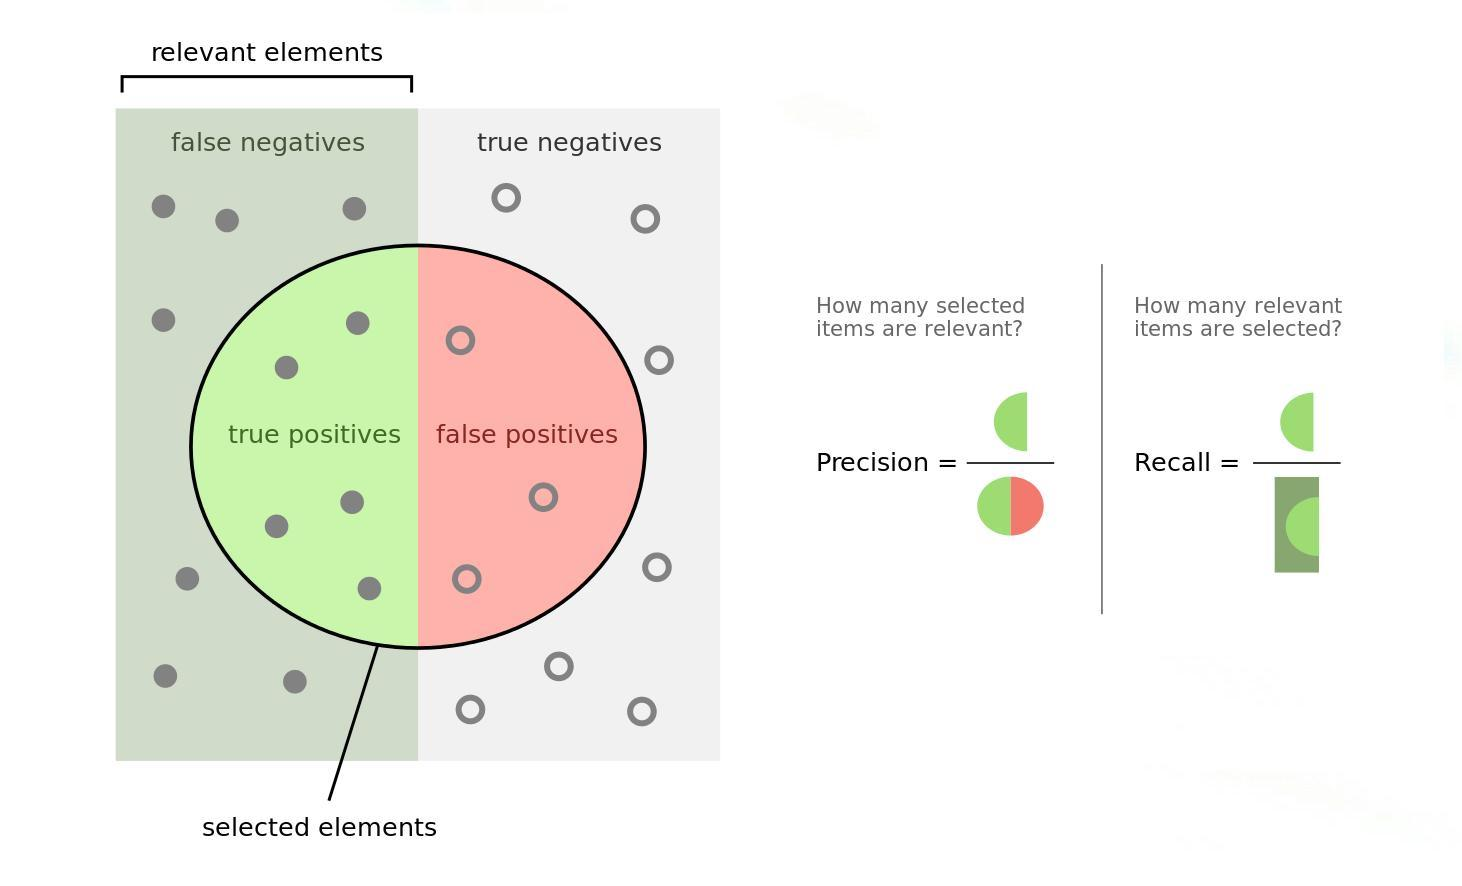
*Image by Walber - Own work, CC BY-SA 4.0, [link](https://commons.wikimedia.org/w/index.php?curid=36926283).*  

Since the survivors are very spread out, we don't expect our model to have a high recall but we would like to have a decent precision for sure.  
Note that with respect to these two metrics, the predict all die model has a score of 0.0 and 0.0!  
Let's see how these two metrics vary in a KNN model when we change the number of neighbors.

In [ ]:
cols = ["PassengerId", "Name", "Pfare", "Pclass", "Embarked"]
y_m = train_male["Survived"]
features = ["Pfare", "Pclass", "Embarked"]
X_m = train_male[features]

numerical_cols = ["Pfare"]
categorical_cols = ["Pclass", "Embarked"]

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

precision_m = []
recall_m = []

for k in range(1, 18):
    pipeline1 = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    precision_m.append(
        cross_val_score(
            pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring="precision"
        ).mean()
    )
    recall_m.append(
        cross_val_score(
            pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring="recall"
        ).mean()
    )

k_range = range(1, 18)
plt.figure(figsize=(7, 5))
plt.plot(k_range, precision_m, label="15-fold precision")
plt.plot(k_range, recall_m, label="15-fold recall")
plt.axhline(y=0.5, color="r")
plt.xlabel("Value of k for KNN")
plt.title("Precision and recall by number of neighbors", fontsize=14)
plt.legend()
plt.show()

We see that an even or odd number of neighbors makes a significant difference in the recall score, while the precision has a nice trend almost independent from the parity.  
It is interesting to see that even when the recall is approximately zero, the models maintain a non-zero precision (even though they are pretty useless).  
Let's select our three values for k in the ensemble to be 1, 3 and 7.  
The reason is that the first two are supposed to detect most of the male survivors with a decent recall while the latter is a pretty good model on his own that will improve the total precision.  
I know this is a completely naive approach to an ensemble but forgive me for this!

In [ ]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", VotingClassifier([("m1", m1), ("m2", m2), ("m3", m3)])),
    ]
)
print(
    "15-fold precision of the ensemble: {:.3f}".format(
        cross_val_score(
            male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring="precision"
        ).mean()
    )
)
print(
    "15-fold recall of the ensemble: {:.3f}".format(
        cross_val_score(
            male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring="recall"
        ).mean()
    )
)
print(
    "15-fold accuracy of the ensemble: {:.3f}".format(
        cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()
    )
)
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print("\nThe following 9 adult males are predicted to live:")
print(test_male.loc[(predictions_m == 1), cols])

The 15-fold precision of the ensemble is 0.562, slightly better than 0.5 and in between the original precisions of the three models.  
I know finding some male survivors is a difficult task, so obtaining this >0.5 accuracy is a good result for me.  
Unfortunately, the 15-fold recall of the ensemble is only 0.318 but at least it did not go down from the original recalls of the three models.  
That is a consequence of the sparsity of the survivors, especially in the second and third classes where our model was not able to extract useful patterns (except one, Mr. Ling Hee in the third class!).  
Since we made 9 predictions, there is a concrete possibility that we find some male survivors this time!  
Just for fun, here I compare the train set, how the ensemble learns it and its predictions for the test data.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
fig.suptitle("Fun comparison of train set vs test set", fontsize=14)
ax[0].set_title("Real train set")
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title("Ensemble learns the train set")
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m, ax=ax[1])
ax[2].set_title("Ensemble predicts the test set")
ax[2].set_ylim(top=60)
a = sns.swarmplot(
    x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m, ax=ax[2]
)

## Submission to Kaggle
Let's change the adult male predictions of the ensemble from the gender model and submit.  
An advantage of the new 100% public leaderboard is that we have now the possibility to count exactly how many correct predictions we make.

In [ ]:
df.loc[n_train : n_all - 1, "Predict"][
    (df.Sex == "male") & (df.WCSurvived.isnull())
] = predictions_m
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"),
    }
)
output.to_csv("WCG_male.csv", index=False)
print("WCG_male submission was successfully saved!")
print("Submission is loading... you scored 0.82296!")

Wow, we scored 82,3% which is 344 passengers, 3 more correct predictions than the WCG + gender model!  
It means 6 out of our 9 male predictions were correct: we finally found a way to guess some male survivors, yeah!
## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.

In [ ]:
train_female = df[:n_train].loc[
    (df.Sex == "female") & (df.WCSurvived.isnull())
]
test_female = df[n_train:].loc[
    (df.Sex == "female") & (df.WCSurvived.isnull())
]

As we did before, let's run a quick analysis to see if we can use more features or if `Age` is again not useful.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Non-WCG females EDA", fontsize=14)
sns.barplot(x="Pclass", y="Survived", data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color="r")
sns.barplot(x="Embarked", y="Survived", data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color="r")
sns.swarmplot(
    x="Pclass", y="Pfare", hue="Survived", data=train_female, ax=ax[1][0]
)
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color="y")
ax[1][0].axhline(y=10, color="y")
a = sns.swarmplot(
    y="Age", x="Pclass", hue="Survived", data=train_female, ax=ax[1][1]
)

For non-WCG females, we definitely see that `Pclass` will be determinant another time and that we have to focus on third-class because the survival rates elsewhere are really high.  
We see there is a decent concentration of green dots in the third class with `Pfare` between 7 and 10, so this may be our best chance to guess some females who died.  
Let's see `Age` and `Pfare` distributions to understand their importance.

In [ ]:
w1 = train_female.loc[train_female["Survived"] == 1, "Pfare"]
w0 = train_female.loc[train_female["Survived"] == 0, "Pfare"]
z1 = train_female.loc[train_female["Survived"] == 1, "Age"]
z0 = train_female.loc[train_female["Survived"] == 0, "Age"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Age and Pfare distributions with hue Survived", fontsize=14)
sns.distplot(w1, bins=35, label="Survived", ax=ax[0], color="c")
sns.distplot(w0, bins=15, label="Not survived", ax=ax[0], color="y")
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label="Survived", ax=ax[1], color="g")
sns.distplot(z0, bins=10, label="Not survived", ax=ax[1], color="r")
ax[1].legend()
fig.show()

We notice `Age` is again not really astonishing while `Pfare` is the one which will help us the most.  
Let's try not to use `Age` and hope for the best: we already found some male survivors so we are more than happy with the result.
## Let's build an ensemble, again
We will make our predictions through an ensemble of three models, using KNNs just for fun.  
I encourage you to fork this notebook and try your models if you don't like this choice!  
Since the classes are very imbalanced another time (the survivors are 4.5 times the deads), accuracy is not a good metric here: for example, cross-validation accuracy for the predict all live model is 0.818!  
Since sklearn metrics use 1 as the default value for positive samples, we have to create our custom metrics that use 0 as the positive value.

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score

# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

Again, we don't expect our model to have a high recall but we would like to have a decent precision.  
Note that with respect to these two custom metrics, the predict all live model has a score of 0.0 and 0.0!  
Let's vary the number of neighbors in a KNN model and see how these two quantities change.

In [ ]:
y_f = train_female["Survived"]
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1, 18):
    pipeline2 = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(
        cross_val_score(
            pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision
        ).mean()
    )
    recall_f.append(
        cross_val_score(
            pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall
        ).mean()
    )

plt.figure(figsize=(7, 5))
plt.plot(k_range, precision_f, label="9-fold precision")
plt.plot(k_range, recall_f, label="9-fold recall")
plt.axhline(y=0.5, color="r")
plt.xlabel("Value of k for KNN")
plt.title("Precision and recall by number of neighbors", fontsize=14)
plt.legend()
plt.show()

Oh, what a strange plot!  
We see the effect of parity is huge, that it takes a while to increase accuracy over 0.5 and that we have to lose almost half of the recall to gain that.  
This time, precision and recall also go to zero at the same time which is a cool thing.  
I'll try to select the KNN models with k values of 4, 9, 11 with a similar logic as before: we take the high recall of the first, we combine it to the high precision of the second and we add the third that has a little bit of both.  
Let's see how it goes...

In [ ]:
f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("voting", VotingClassifier([("f1", f1), ("f2", f2), ("f3", f3)])),
    ]
)
print(
    "9-fold precision of the ensemble: {:.3f}".format(
        cross_val_score(
            female_pipeline, X_f, y_f, cv=9, scoring=custom_precision
        ).mean()
    )
)
print(
    "9-fold recall of the ensemble: {:.3f}".format(
        cross_val_score(
            female_pipeline, X_f, y_f, cv=9, scoring=custom_recall
        ).mean()
    )
)
print(
    "9-fold accuracy of the ensemble: {:.3f}".format(
        cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()
    )
)
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print("\nThe following 6 non-WCG females are predicted to die:")
print(test_female.loc[(predictions_f == 0), cols])

Wow, the 9-fold precision for the ensemble is 0.571, at least it did not go down!  
The recall isn't great but it's ok, also this one is a difficult task and we don't expect a lot more than this.      
I'm surprised that we made only 6 predictions, but it is what it is with such a small test set (only 97 rows).  
As I did before, here I compare the train set, how the ensemble learns it and its predictions for the test data.  
Thanks to this plot, we can also see that non-WCG females in the third class are not distributed as in the train data and this may explain why we made only a few predictions.  

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
fig.suptitle("Fun comparison of train set vs test set", fontsize=14)
ax[0].set_title("Real train set")
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title("Ensemble learns the train set")
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f, ax=ax[1])
ax[2].set_title("Ensemble predicts the test set")
ax[2].set_ylim(top=55)
a = sns.swarmplot(
    x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f, ax=ax[2]
)

It's actually pretty funny to see how the ensemble learns the train set but hey, if it works I keep it!
## Final Submission
Now it's time to see if we have a good model that predicts which females die.  
Hopefully, we have the same increment as before and have the best Titanic model ever!  
Let's change these female predictions from the previous model and submit to Kaggle.

In [ ]:
df.loc[n_train : n_all - 1, "Predict"][
    (df.Sex == "female") & (df.WCSurvived.isnull())
] = predictions_f
output = pd.DataFrame(
    {
        "PassengerId": df[891:1309].PassengerId,
        "Survived": df[891:1309].Predict.astype("int"),
    }
)
output.to_csv("WCG_male_female.csv", index=False)
print("WCG_male_female was successfully saved!")
print("Submission is loading... you scored 0.82775!")

Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  
Unfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  
Well, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      
If I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  
# Conclusion
First of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      
Secondly, thank you for reading my notebook!  
I hope you liked it: this was my attempt to push the top score higher and even if I did not succeed, it was still a nice journey.  
I had to look at the problem from another perspective and not using the `Age` column ended up being a way to find some male survivors, so at least I made an important contribution.  
This notebook proves another time that the two tasks of predicting adult male survivors and females not in a group who died are very different and it is really difficult to do both well with the same approach.  
I believe it is possible to increase the public score again ensembling this model with others, mostly to correct some of the female predictions: I think the maximum score achievable could be around 350 passengers, which is 83,7%.  
That being said, I finish this notebook with a short summary of what we did.
# Summary of what we did
This notebook proved that male survivors can be found with simple elements and thus the old top scores have the potential to be improved, especially if we use the WCG model as a strong baseline.  
Here's the pipeline we followed to reach top 1% in the competition and an histogram of Titanic LB scores in September 2020.
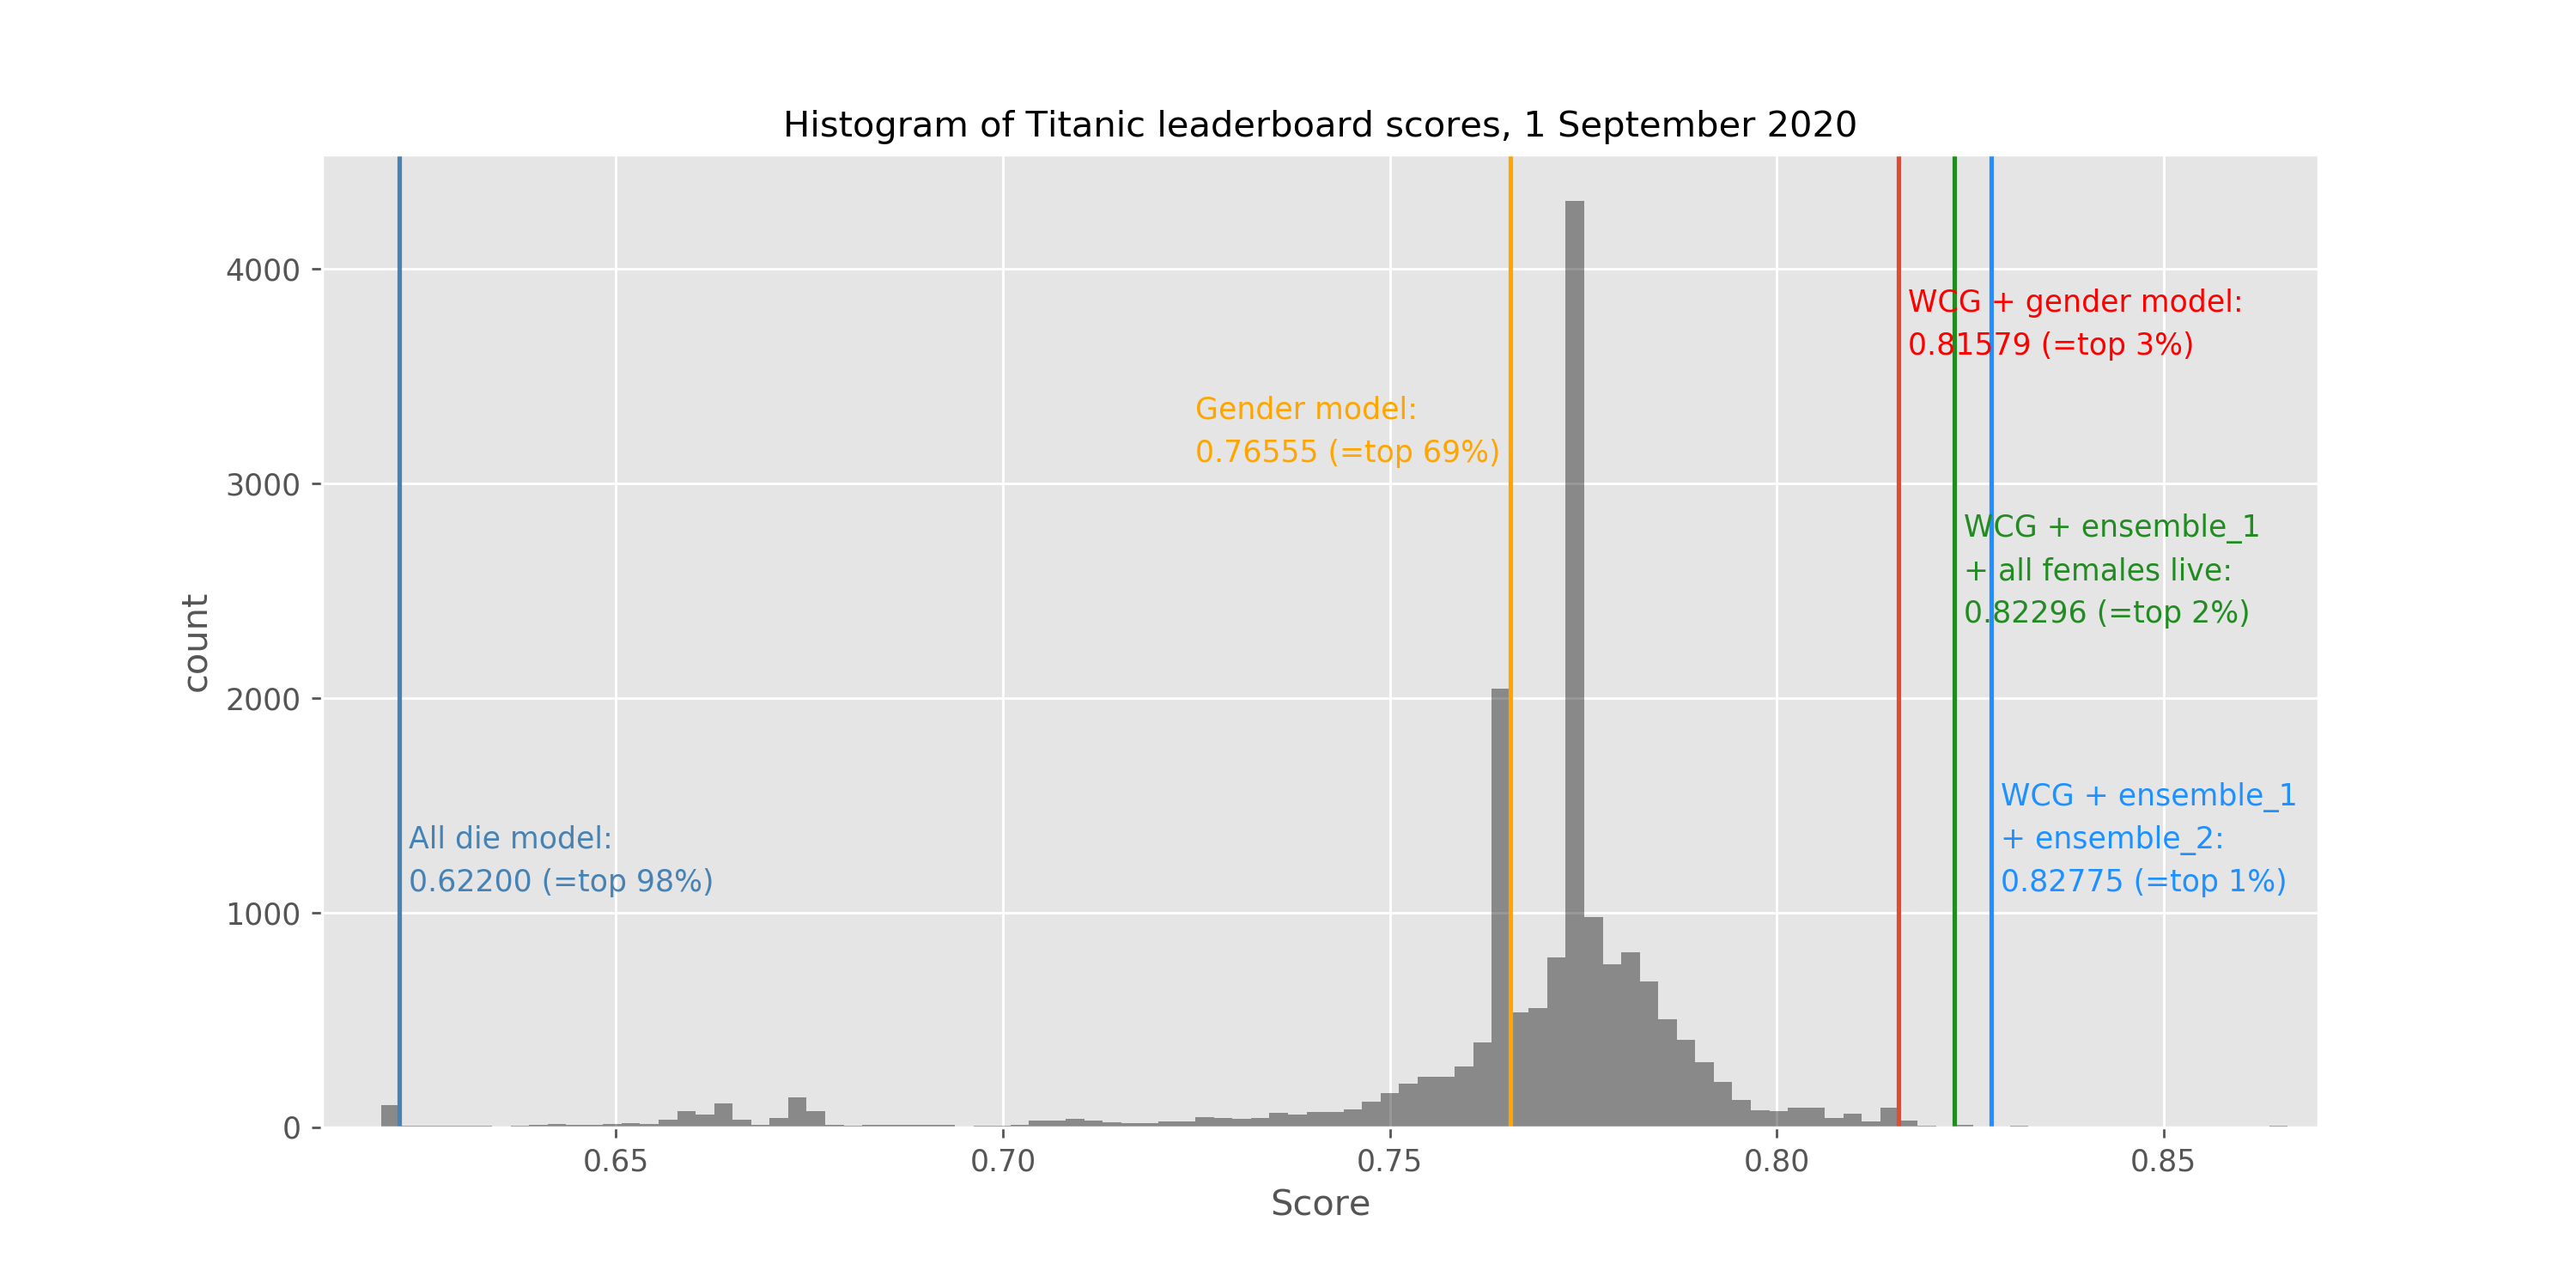
First, the passengers (train + test) were divided into four groups:
1. Adult males - 60% of the population (A)
1. Young boys (with Master title) - 5% of the population (B)
1. Females that have children, sisters, or mothers (brothers and husbands are optional) - 13% of the population (C)
1. Females that have brothers, or husbands (no children, no sisters, no mothers) or are traveling alone - 22% of the population (D)

Next, we built 3 classifiers:
1. **WCG** on top of the **gender model** to classify (B) + (C)
1. **Ensemble_1** of KNNs to classify (A)
1. **Ensemble_2** of KNNs to classify (D)

Finally we assembled the models. Here are the public scores:
1. **WCG + gender model** scores 81,6% which is 341 correct predictions
1. **WCG + ensemble_1 + all females live** scores 82,3% which is 344 correct predictions
1. **WCG + ensemble_1 + ensemble_2** scores 82,8% which is 346 correct predictions

See you soon in the next one and good luck passing 83%!  
Please let me know down in the comments your suggestions or if you find errors in the code!

# 总体思路
将所有乘客分成4类:
1. man(成年男性)
2. boy(男孩)
3. 有其他WCG成员的woman(包括成年女性与女孩)
4. 没有其他WCG成员的woman(包括成年女性与女孩)

2与3用WCG模型
1与4分别用两套"Voting of KNN模型"独立建模。

## 流程图:
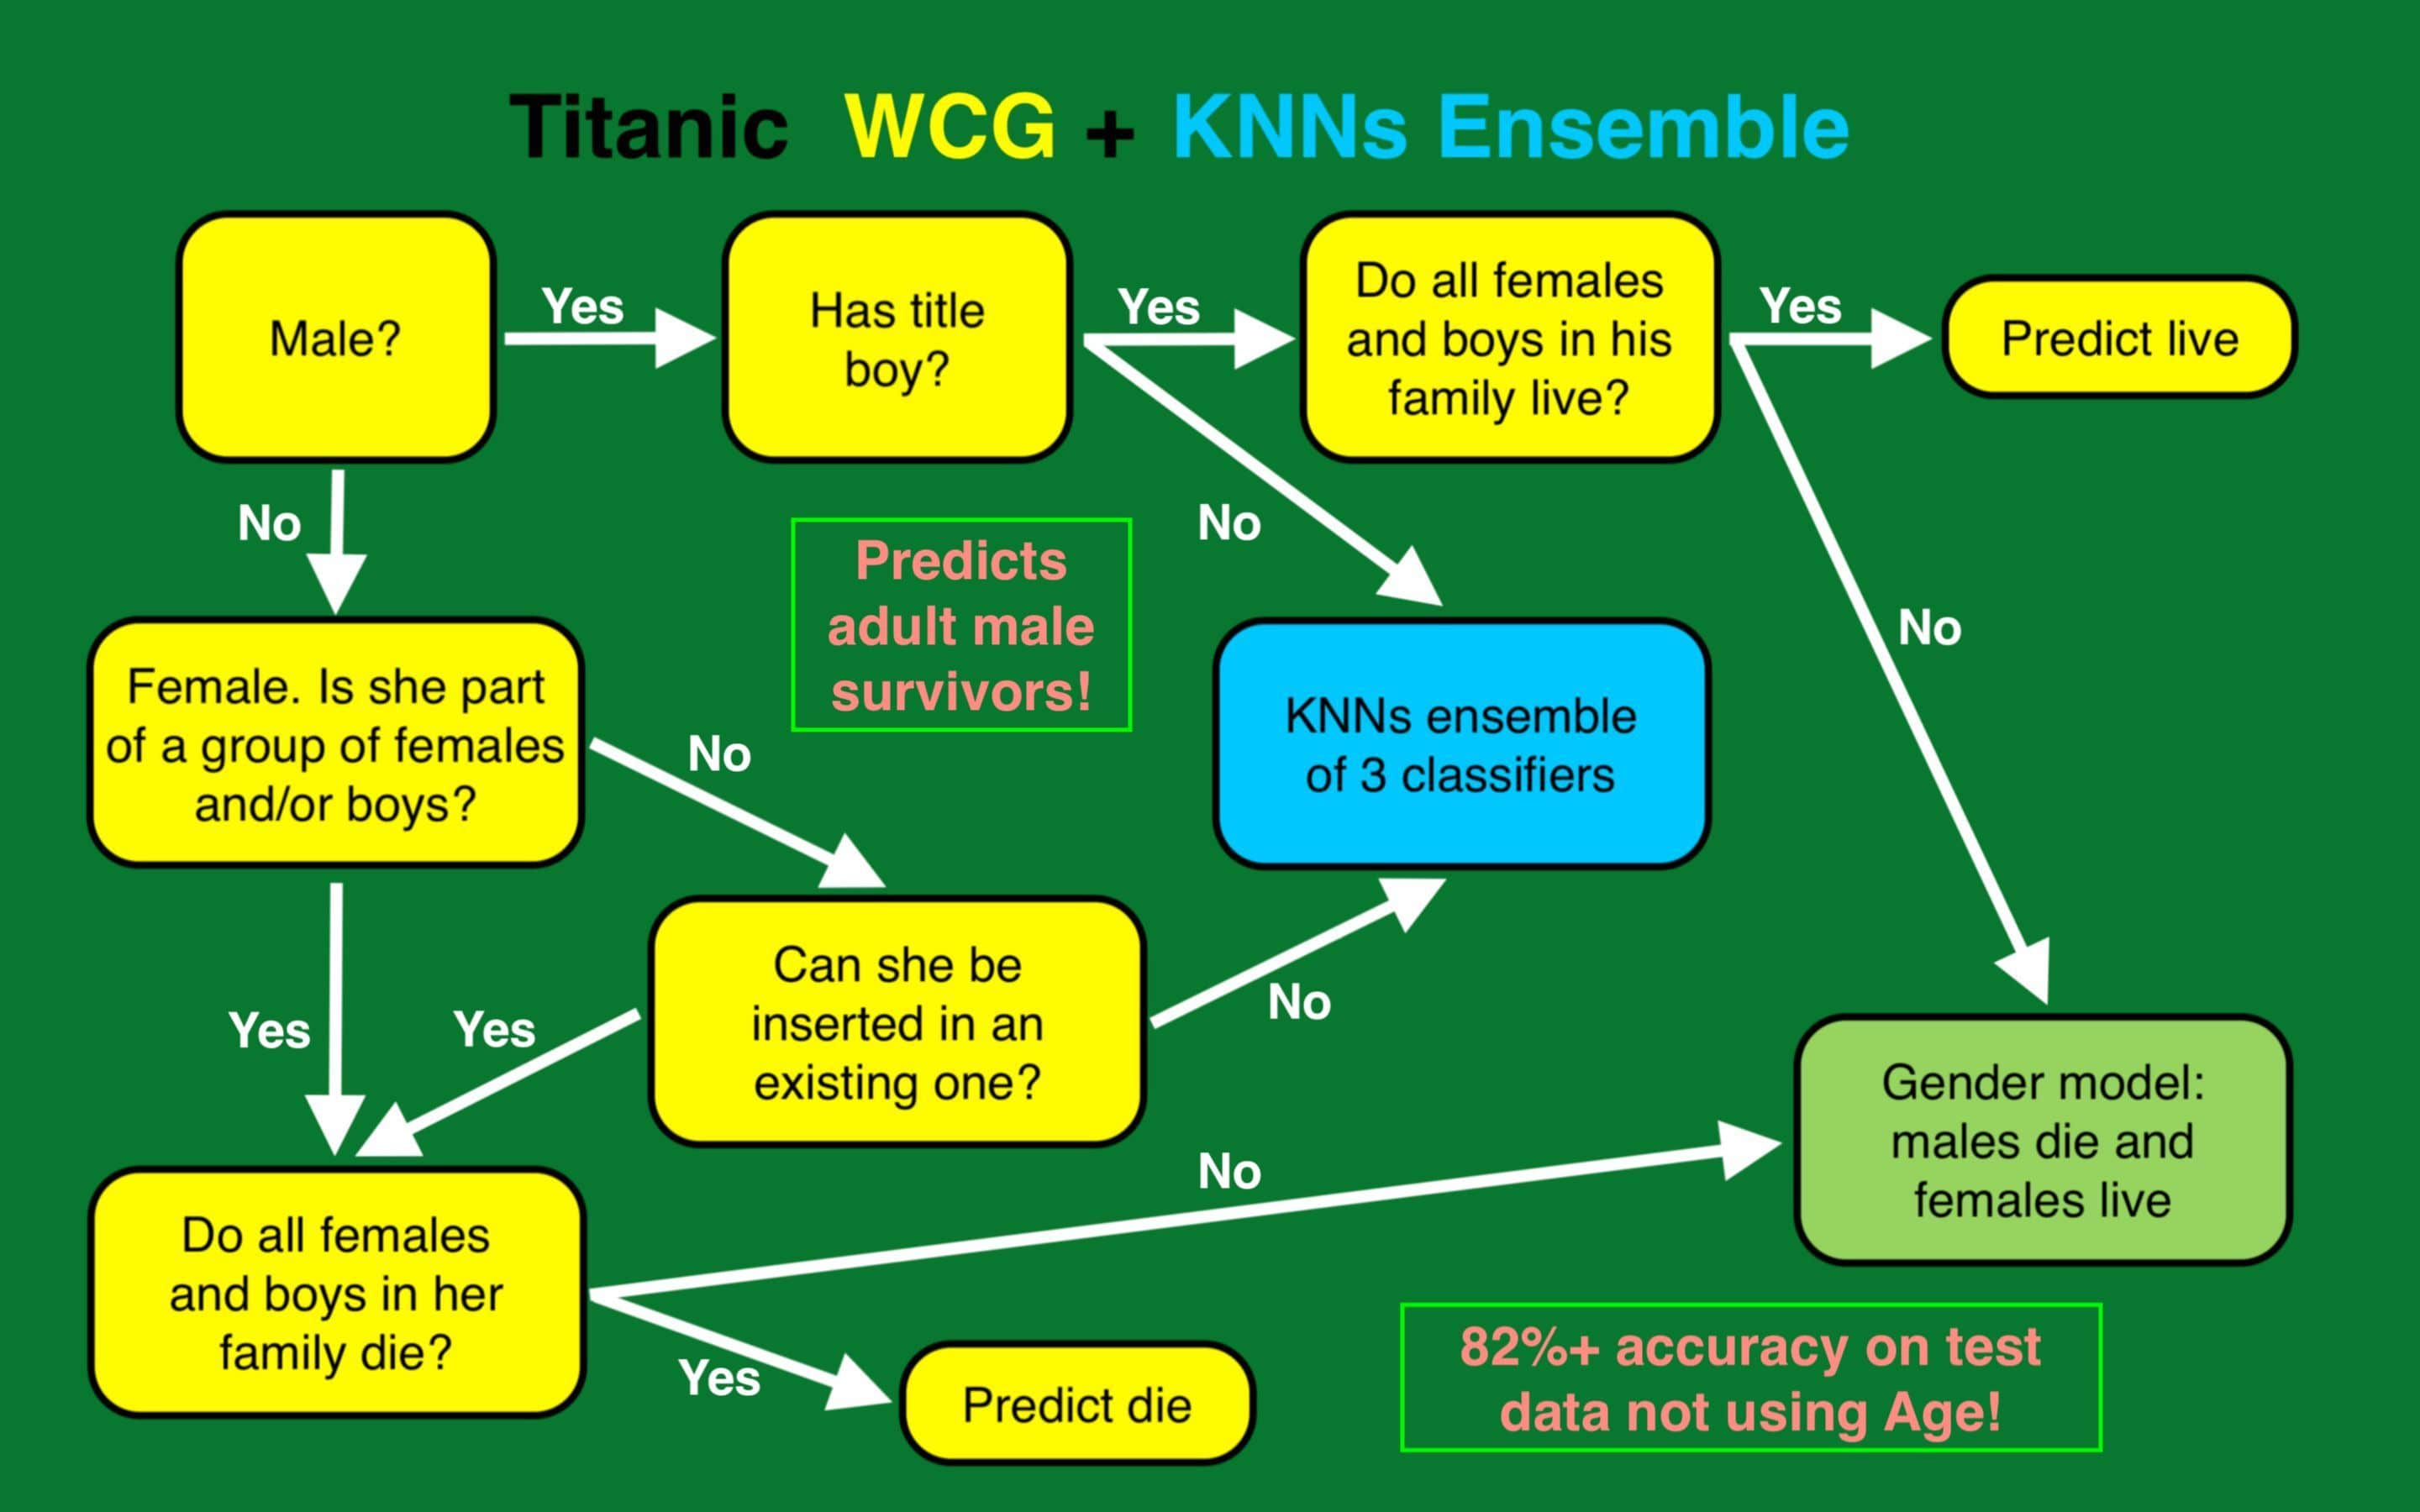

# notebook的参考
这个notebook是在[Link](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1)的基础上进行改写的.